Load some standard libraries

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

We will use the following libraties from spacebench.

In [2]:
from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
)

WARNING ⚠️ : this package contains data with synthetic outcomes!
No inferences about the source data collection can be made.
By using it, you agree to understand its limitations and purpose.
The sole objective of SpaCE is to support the development of new
spatial confounding methods.



Load the datamaster to list available datasets

In [3]:
DataMaster().list_envs()

['healthd_dmgrcs_mortality_disc',
 'cdcsvi_limteng_hburdic_cont',
 'climate_relhum_wfsmoke_cont',
 'climate_wfsmoke_minrty_disc',
 'healthd_hhinco_mortality_cont',
 'healthd_pollutn_mortality_cont',
 'county_educatn_election_cont',
 'county_phyactiv_lifexpcy_cont',
 'county_dmgrcs_election_disc',
 'cdcsvi_nohsdp_poverty_cont',
 'cdcsvi_nohsdp_poverty_disc']

Create the environment.

In [115]:
envname = "healthd_pollutn_mortality_cont"
env = SpaceEnv(envname)
env.__dict__.keys()

Downloaded: filename healthd_pollutn_mortality_cont.zip, id 7317966, saved to /var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/healthd_pollutn_mortality_cont.zip


dict_keys(['name', 'datamaster', 'api', 'dir', 'config', 'metadata', 'outcome', 'counterfactuals', 'treatment', 'treatment_values', 'graph', 'edge_list', 'coordinates', 'covariates_df', 'covariate_groups', 'confounding_score', 'smoothness_score'])

Example of generating a dataset.

In [116]:
dataset = env.make()
dataset

SpaceDataset with a missing spatial confounder:
  treatment: (3109,) (continuous)
  outcome: (3109,)
  counterfactuals: (3109, 100)
  covariates: (3109, 27)
  missing covariates: (3109, 6)
  confounding score of missing: {'erf': 0.0404, 'ate': nan, 'ite': 0.2542, 'importance': 0.0134}
  spatial smoothness score of missing: [0.93, 0.93, 0.96, 0.88, 0.92, 0.82]
  graph edge list: (9237, 2)
  graph node coordinates: (3109, 2)
  parent SpaceEnv: healthd_pollutn_mortality_cont
WARNING ⚠️ : this dataset contains a (realistic) synthetic outcome!
By using it, you agree to understand its limitations.The variable names have been masked to emphasize that noinferences can be made about the source data.

In [117]:
print(np.isnan(dataset.treatment).mean())
print(np.isnan(dataset.outcome).mean())
print(np.isnan(dataset.counterfactuals).mean())
print(np.isnan(dataset.covariates).mean())

# replace covariates with mean when missing
for j in range(dataset.covariates.shape[1]):
    is_nan = np.isnan(dataset.covariates[:, j])
    dataset.covariates[is_nan, j] = np.nanmean(dataset.covariates[:, j])

print(np.isnan(dataset.treatment).mean())
print(np.isnan(dataset.outcome).mean())
print(np.isnan(dataset.counterfactuals).mean())
print(np.isnan(dataset.covariates).mean())


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


We can loop over all possible datasets using the make_all method.

Text(0.5, 0.98, 'Distribution of confounding and smoothness')

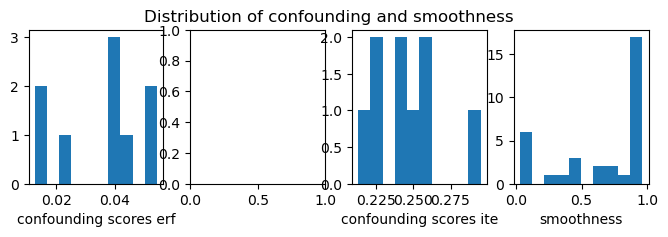

In [118]:
confounding_scores_ate = []
confounding_scores_erf = []
confounding_scores_ite = []
smoothness_scores = []
for dataset in env.make_all():
    # replace covariates with mean when missing
    for j in range(dataset.covariates.shape[1]):
        is_nan = np.isnan(dataset.covariates[:, j])
        dataset.covariates[is_nan, j] = np.nanmean(dataset.covariates[:, j])
        
    confounding_scores_erf.append(dataset.confounding_score['erf'])
    if dataset.has_binary_treatment():
        confounding_scores_ate.append(dataset.confounding_score['ate'])
    confounding_scores_ite.append(dataset.confounding_score['ite'])
    smoothness_scores.extend(dataset.smoothness_score)

fig, ax = plt.subplots(1, 4, figsize=(8, 2))
ax[0].hist(confounding_scores_erf)
ax[0].set_xlabel("confounding scores erf")
if len(confounding_scores_ate) > 0:
    ax[1].hist(confounding_scores_ate)
    ax[1].set_xlabel("confounding scores ate")
ax[2].hist(confounding_scores_ite)
ax[2].set_xlabel("confounding scores ite")
ax[3].hist(smoothness_scores)
ax[3].set_xlabel("smoothness")
plt.suptitle("Distribution of confounding and smoothness")

Let's now illustrate how to use the evaluator. On **one** dataset.
We will compare two methods. These methods are not real competitive spatial confounding 
methods, but they are easy to implement and illustrate the use of the evaluator.

One model is a simple xgboost regression model without any type of spatial confounding correction.
The other model uses the coordinates (lon/lats) as features in the model.

In [119]:
def estimate_counterfactuals(model, dataset: SpaceDataset, use_coords: bool):
    """Helper function to fit a model and predict counterfactuals"""
    treatment = dataset.treatment[:, None]
    # covariates = dataset.unmasked_covariates
    covariates = dataset.covariates
    outcome = dataset.outcome

    # replace covariates with mean when missing
    for j in range(dataset.covariates.shape[1]):
        is_nan = np.isnan(dataset.covariates[:, j])
        dataset.covariates[is_nan, j] = np.nanmean(dataset.covariates[:, j])

    # make train matrix
    trainmat = np.hstack([covariates, treatment])
    if use_coords:
        coords = np.array(dataset.coordinates)
        trainmat = np.hstack([trainmat, coords])

    # fit model
    model.fit(trainmat, outcome)

    # predict counterfactuals
    tvals = dataset.treatment_values
    counterfactuals = []
    for tval in tvals:
        trainmat = np.hstack([covariates, np.full_like(treatment, tval)])
        if use_coords:
            trainmat = np.hstack([trainmat, coords])
        counterfactuals.append(model.predict(trainmat))
    counterfactuals = np.stack(counterfactuals, axis=1)

    return counterfactuals

Now use the `DatasetEvaluator` class.

(3109, 27)
Errors no coords. ERF: 0.127528, PEHE: 0.43
Errors with coords, ERF: 0.129208, PEHE: 0.44


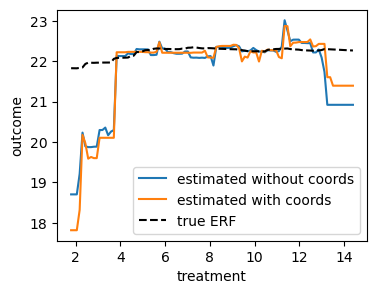

In [120]:
dataset = env.make()
print(dataset.covariates.shape)
model = LinearRegression()
model_coords = LinearRegression()
model = XGBRegressor()
model_coords = XGBRegressor()


# generate counterfactuals and estimate exposure response function
cfs = estimate_counterfactuals(model, dataset, use_coords=False)
erf = cfs.mean(0)

cfs_coords = estimate_counterfactuals(model_coords, dataset, use_coords=True)
erf_coords = cfs_coords.mean(0)

# evaluate performance
evaluator = DatasetEvaluator(dataset)

err = evaluator.eval(erf=erf, counterfactuals=cfs)
msg = f"Errors no coords. ERF: {err['erf']:.6f}, PEHE: {err['pehe']:.2f}"
print(msg)

err_coords = evaluator.eval(erf=erf_coords, counterfactuals=cfs_coords)
msg = f"Errors with coords, ERF: {err_coords['erf']:.6f}, PEHE: {err_coords['pehe']:.2f}"
print(msg)

# plot comparing estimated and true erf
erf_true = dataset.erf()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(dataset.treatment_values, erf, label="estimated without coords")
ax.plot(dataset.treatment_values, erf_coords, label="estimated with coords")
ax.plot(dataset.treatment_values, erf_true, label="true ERF", linestyle="--", color="k")
ax.set_xlabel("treatment")
ax.set_ylabel("outcome")
ax.legend();

Let us know loop over all datasets and compare the two models. The `EnvEvaluator` evalautor is designed for this task. But we need an evaluator for each model.

In [121]:
# for each masked variable
env_evaluator = EnvEvaluator(env)
env_evaluator_coords = EnvEvaluator(env)

for dataset in tqdm(env.make_all()):
    cfs = estimate_counterfactuals(model, dataset, use_coords=False)
    erf = cfs.mean(0)
    cfs_coords = estimate_counterfactuals(model_coords, dataset, use_coords=True)
    erf_coords = cfs_coords.mean(0)

    err = env_evaluator.add(dataset, erf=erf, counterfactuals=cfs)
    err_coords = env_evaluator_coords.add(
        dataset, erf=erf_coords, counterfactuals=cfs_coords
    )

9it [00:10,  1.14s/it]


On average, it does not seem like including the coordinates helped.

In [122]:
# Average metrics allong the curve
print("Model without coordinates")
summary = env_evaluator.summarize()
print(
    f"PEHE (av): {summary['pehe'].mean():.4f}",
    f"ERF bias^2: {np.square(summary['erf_bias']).mean():.4f}",
    f"ERF variance: {(summary['erf_variance']).mean():.4f}"
)

print("Model with coordinates")
summary = env_evaluator_coords.summarize()
print(
    f"PEHE (av): {summary['pehe'].mean():.4f}",
    f"ERF bias^2: {np.square(summary['erf_bias']).mean():.4f}",
    f"ERF variance: {(summary['erf_variance']).mean():.4f}"
)

Model without coordinates
PEHE (av): 0.3807 ERF bias^2: 0.0233 ERF variance: 0.0038
Model with coordinates
PEHE (av): 0.3679 ERF bias^2: 0.0216 ERF variance: 0.0046


We may sometimes prefer to use the dataset evaluator and keep metrics in each loop for a more detailed analysis.

In [123]:
# for each masked variable
smoothness_scores = []
confounding_scores = []
errors = []
erf_error_coords = []

for dataset in tqdm(env.make_all()):
    evaluator = DatasetEvaluator(dataset)

    cfs = estimate_counterfactuals(model, dataset, use_coords=False)
    erf = cfs.mean(0)
    cfs_coords = estimate_counterfactuals(model_coords, dataset, use_coords=True)
    erf_coords = cfs_coords.mean(0)

    err = evaluator.eval(erf=erf, counterfactuals=cfs)
    err_coords = evaluator.eval(erf=erf_coords, counterfactuals=cfs_coords)

    errors.append((err["erf"]))
    erf_error_coords.append((err_coords["erf"]))

    smoothness_scores.append(np.mean(dataset.smoothness_score))
    confounding_scores.append(dataset.confounding_score['erf'])

9it [00:09,  1.10s/it]


Text(0.5, 1.0, 'Effect of adding coordinates to response curve by confounding score')

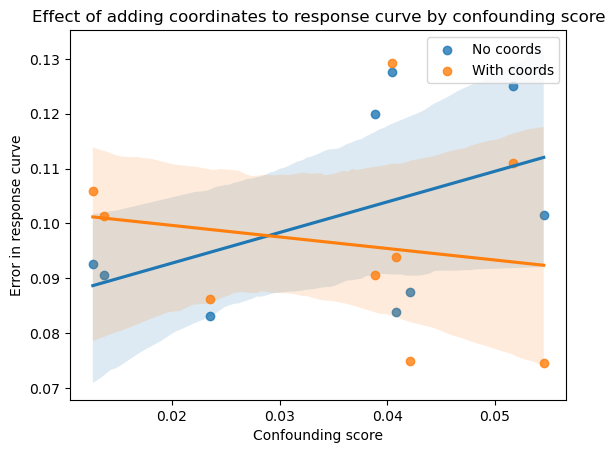

In [124]:
sns.regplot(x=confounding_scores, y=errors, label="No coords")
sns.regplot(x=confounding_scores, y=erf_error_coords, label="With coords")
plt.xlabel("Confounding score")
plt.ylabel("Error in response curve")
plt.legend()
plt.title("Effect of adding coordinates to response curve by confounding score")

Text(0.5, 1.0, 'Effect of adding coordinates to response curve by smoothness score')

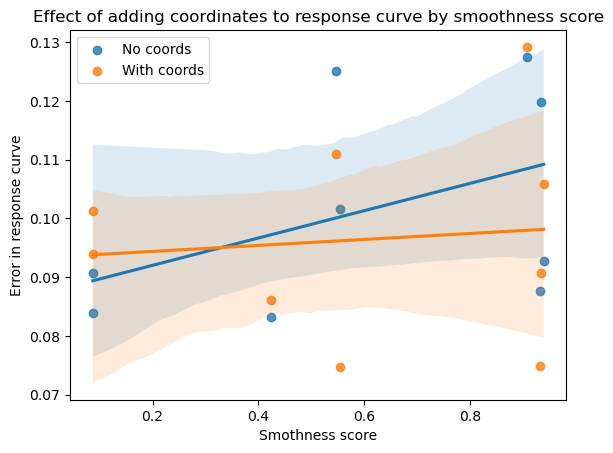

In [125]:
sns.regplot(x=smoothness_scores, y=errors, label="No coords")
sns.regplot(x=smoothness_scores, y=erf_error_coords, label="With coords")
plt.xlabel("Smothness score")
plt.ylabel("Error in response curve")
plt.legend()
plt.title("Effect of adding coordinates to response curve by smoothness score")

In [126]:
cs_thresh = np.quantile(confounding_scores, 0.5)
ss_thresh = np.quantile(smoothness_scores, 0.5)

In [127]:
erf_errors = dict(
    smoothness=["low" if x < ss_thresh else "high" for x in smoothness_scores],
    confounding=["low" if x < cs_thresh else "high" for x in confounding_scores],
    model_without_coords=errors,
    model_with_coords=erf_error_coords,
)
erf_errors = pd.DataFrame(erf_errors)
erf_errors.groupby(["smoothness", "confounding"]).agg(["mean", "std", "count"])

model_without_coords                 model_with_coords  \
                                       mean       std count              mean   
smoothness confounding                                                          
high       high                    0.105562  0.020266     3          0.092924   
           low                     0.106290  0.019249     2          0.098310   
low        high                    0.104492  0.029187     2          0.102476   
           low                     0.086929  0.005304     2          0.093739   

                                        
                             std count  
smoothness confounding                  
high       high         0.031424     3  
           low          0.010754     2  
low        high         0.012034     2  
           low          0.010696     2

In [128]:
erf_errors.drop(columns='smoothness').groupby("confounding").agg(["mean", "std", "count"])

model_without_coords                 model_with_coords            \
                            mean       std count              mean       std   
confounding                                                                    
high                    0.105134  0.020461     5          0.096745  0.023607   
low                     0.096609  0.016057     4          0.096024  0.009146   

                   
            count  
confounding        
high            5  
low             4

In [129]:
erf_errors.drop(columns='confounding').groupby("smoothness").agg(["mean", "std", "count"])

model_without_coords                 model_with_coords            \
                           mean       std count              mean       std   
smoothness                                                                    
high                   0.105853  0.017267     5          0.095078  0.023051   
low                    0.095710  0.019904     4          0.098107  0.010576   

                  
           count  
smoothness        
high           5  
low            4

We can see that adding coordinates gives worse results when smoothnes is low. Both models do a bit betteror about the same when confounding is low.